# Taller de Segmentación II, técnicas más avanzadas

En este taller practicaremos diversas técnicas de segmentación que involucran clustering, transformación watershed, contornos activos ,etc. Sin embargo, todo lo que hemos visto hasta ahora se puede (y en algunos casos será necesario) usar, como filtrado, morfología matemática, segmentación por umbralización, etc.

In [23]:
# Imports 
from skimage import io
from os.path import join
import numpy as np
from skimage import morphology
from skimage.filters import threshold_multiotsu, sobel
from skimage.color import label2rgb, rgb2gray
from skimage import segmentation
from skimage.measure import regionprops
from skimage import util
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.cluster import k_means

import matplotlib.pyplot as plt

DIR = "images" 

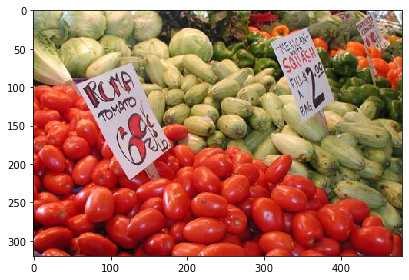

In [2]:
im = io.imread(join(DIR, "verduras.ppm"))
io.imshow(im);

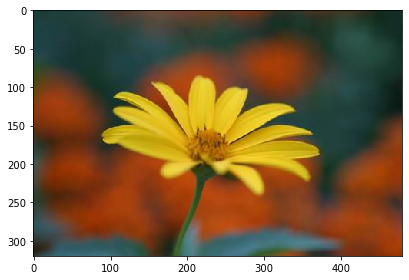

In [3]:
flor = io.imread(join(DIR, "flor.ppm"))
io.imshow(flor);

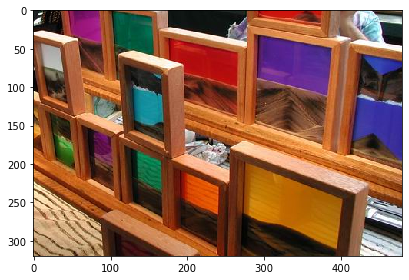

In [4]:
colores = io.imread(join(DIR, "colores.ppm"))
io.imshow(colores);

### Realice los puntos 1 y 2 sobre las imágenes de verduras, flor y colores.

## 1. Segmentación mediante clustering usando la información de Color

En los puntos a continuación, use la implementación de Kmeans de scikit learn: `sklearn.cluster.KMeans`.
    
(A) Use `KMeans()` para realizar una segmentación mediante agrupación del Color RGB (transforme la imagen en un conjunto de datos de N filas y 3 Columnas (RGB) ). Suministre un valor de K. El procedimiento deberá generar una imagen en escala de grises que muestre los clusters finales.

(A.1) Realice el clustering usando como centros (de cluster) iniciales valores aleatorios.
(A.2) Intente muestrear pixeles de la imagen para encontrar los centros de clusters. Elija un pixel y convierta su valor en un centro si es lo suficientemente diferente de los centros ya seleccionadas. Repita hasta obtener K centros diferentes.
(A.3) Use un método inteligente para encontrar los centros de los clusters. Una posibilidad es realizar un histograma de color y encontrar K picos para tomarlos como centros. Otra posibilidad es realizar una umbralizacion automática (por ejemplo el método de Otsu) y determinar el centro de cada región umbralizada. 

Grafique una figura comparando las segmentaciones de los métodos usados anteriormente. ¿Qué resultado es mejor?

(B) Realice de nuevo un clustering (puede ser con centros aleatorios, o inteligentes), intente determinar de forma automática el número K de clusters a usar. Es libre de encontrar un método. Algunas sugerencias son: 
- Puede comenzar desde el histograma de color, ya que K está estrechamente relacionado con el número de picos en el histograma. No todos los picos son necesarios, ya que solo desea los dominantes, por lo que debe elegir los que ocupan una cierta fracción de la imagen en términos de píxeles.
- También puede intentar agrupar utilizando diferentes K y elegir el mejor. La métrica podría estar relacionada con la distancia entre grupos y la varianza dentro de cada grupo (o usar métricas como el coeficiente de silueta).


In [6]:
### punto A     
verduras = im.reshape([im.shape[0] * im.shape[1], 3])
kmeans = KMeans(n_clusters=8, random_state=0).fit(verduras)

In [9]:
result = kmeans.predict(verduras).reshape(im.shape[0],im.shape[1])

<ipython-input-12-86721d33c6c6>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(label2rgb(result))


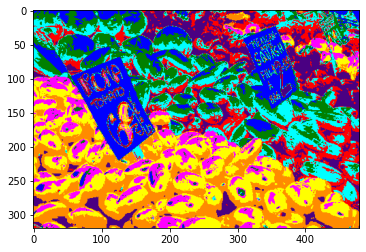

In [12]:
plt.imshow(label2rgb(result))

In [15]:
## Punto A1
kmeans_random = KMeans(n_clusters=8, init = 'random', random_state=0).fit(verduras)
result_random = kmeans.predict(verduras).reshape(im.shape[0],im.shape[1])

<ipython-input-16-9189738b22b0>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(label2rgb(result_random))


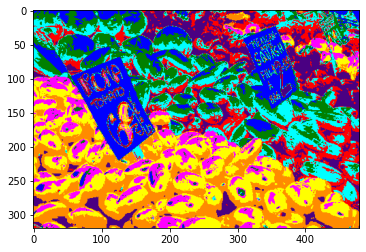

In [16]:
plt.imshow(label2rgb(result_random))

In [19]:
im.shape

(320, 480, 3)

In [30]:
# Punto B
verduras_small = resize(im,(int(im.shape[0]/10),int(im.shape[1]/10),3))
verduras_small_2 = verduras_small.reshape(verduras_small.shape[0]*verduras_small.shape[1],3) 
kmeans_small = KMeans(n_clusters=3, random_state=0).fit(verduras_small_2)

In [31]:
# cluster = siempre va a tener 3 centroides
# image = imagen mas pequena 
# k = numero de cluster a buscar.
# Retorna lista cluster

def getCenterCluster(image, clusters, k, n_sample):
    lista_clusters = list()
    lista_clusters.append(clusters[0])
    lista_clusters.append(clusters[1])
    lista_clusters.append(clusters[2])
    while (len(lista_clusters) < k):
        indices = np.random.choice()

array([[0.70696811, 0.61990071, 0.47717061],
       [0.72086326, 0.1796334 , 0.1332848 ],
       [0.40574597, 0.34658278, 0.19269981]])

## 2. Construya superpixels y realice de nuevo un clustering

#### 2(A)  SLIC: Este algoritmo simplemente realiza K-means en un espacio 5D que junta la información de color y de espacio de la imagen.  El parámetro de `compactness` intercambia similitud de color y proximidad, mientras que `n_segments` elige el número de centros para kmeans.

Use `skimage.segmentation.slic` para generar 200 superpixels (no tan cuadrados), visualice los resultados marcando los bordes (`mark_boundaries`). La salida de la técnica de SLIC es una imagen de etiquetas asignando un número entero a cada superpixel (o region). Forme una nueva imagen colocando en cada superpixel el valor promedio de los valores (rgb por ejemplo) dentro de cada superpixel (visualice el resultado). Por último, realice una segmentación similar a la del punto 1 usando esta nueva imagen de superpixels.

#### 2(B) Watershed para generar superpixels.  
En lugar de tomar una imagen en color como entrada, la transformación Watershed requiere una imagen de gradiente en escala de grises, donde los píxeles brillantes denotan un límite entre regiones. El algoritmo ve la imagen como un paisaje, con píxeles brillantes que forman picos altos. Este paisaje luego se inunda desde los marcadores dados, hasta que las cuencas inundadas encuentran los picos. Cada cuenca distinta forma entonces un segmento de imagen diferente.

Al igual que con SLIC, hay un parámetro `compactness` adicional que dificulta que los marcadores inunden píxeles lejanos. Esto hace que las regiones de las cuencas hidrográficas tengan una forma más regular. Realice el siguiente procedimiento para generar superpixels:
- Determine la magnitud del gradiente de la imagen (por ejemplo aplicando el filtro `sobel` sobre una versión en escala de grises de la imagen.
- Realice una transformación Watershed (`segmentation.watershed`) sobre la imagen de gradiente con los parámetros `markers=200` y `compactness=0.001`). 

El anterior procedimiento genera una imagen de etiquetas. Visualice los bordes de la regiones generadas (como con SLIC. Forme una nueva imagen colocando en cada superpixel el valor promedio de los valores (rgb por ejemplo) dentro de cada superpixel (visualice el resultado). Por último, realice una segmentación similar a la del punto 1 usando esta nueva imagen de superpixels.

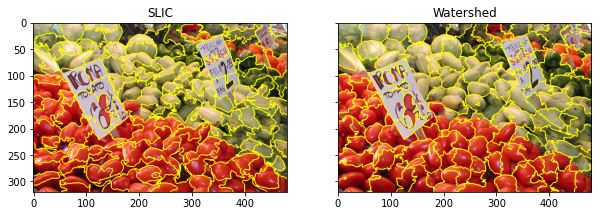

## 3.  Contornos activos sobre la oveja Shaun

El modelo de contorno activo es un método para ajustar splines abiertos o cerrados a líneas o bordes en una imagen. Funciona minimizando una energía que está definida en parte por la imagen y en parte por la forma de la spline: longitud y suavidad. La minimización se realiza implícitamente en la energía de la forma y explícitamente en la energía de la imagen. Utilice `skimage.segmentation.active_contour` para segmentar los ojos de la oveja. Para ello necesitara un contorno inicial (ojo son coordenadas no pixeles y regiones) en el parámetro `snake`. Para generar este contorno segmente el rostro de shaun sin las orejas (umbralización, morfología matemática, etc), determine el contorno del rostro de shaun (por ejemplo usando `skimage.segmentation.find_boundaries`) y luego determine sus coordenadas (por ejemplo mediante `skimage.measure.regionprops` y la propiedad `coords`. Estas coordenadas serán el "snake". 